### 1. Explain the architecture of Faster R-CNN and its components. Discuss the role of each component in the object detection pipeline.

### Architecture Faster R-CNN:

The most widely used state of the art version of the R-CNN family — Faster R-CNN was first published in 2015. This article, the third and final one of a series to understand the fundamentals of current day object detection elaborates the technical details of the Faster R-CNN detection pipeline. For a review of its predecessors, check out these summaries: Regions with CNN (R-CNN) and Fast R-CNN.

In the R-CNN family of papers, the evolution between versions was usually in terms of computational efficiency (integrating the different training stages), reduction in test time, and improvement in performance (mAP). These networks usually consist of — a) A region proposal algorithm to generate “bounding boxes” or locations of possible objects in the image; b) A feature generation stage to obtain features of these objects, usually using a CNN; c) A classification layer to predict which class this object belongs to; and d) A regression layer to make the coordinates of the object bounding box more precise.


The only stand-alone portion of the network left in Fast R-CNN was the region proposal algorithm. Both R-CNN and Fast R-CNN use CPU based region proposal algorithms, Eg- the Selective search algorithm which takes around 2 seconds per image and runs on CPU computation. The Faster R-CNN [3] paper fixes this by using another convolutional network (the RPN) to generate the region proposals. This not only brings down the region proposal time from 2s to 10ms per image but also allows the region proposal stage to share layers with the following detection stages, causing an overall improvement in feature representation. In the rest of the article, “Faster R-CNN” usually refers to a detection pipeline that uses the RPN as a region proposal algorithm, and Fast R-CNN as a detector network.

### Region Proposal Network (RPN):

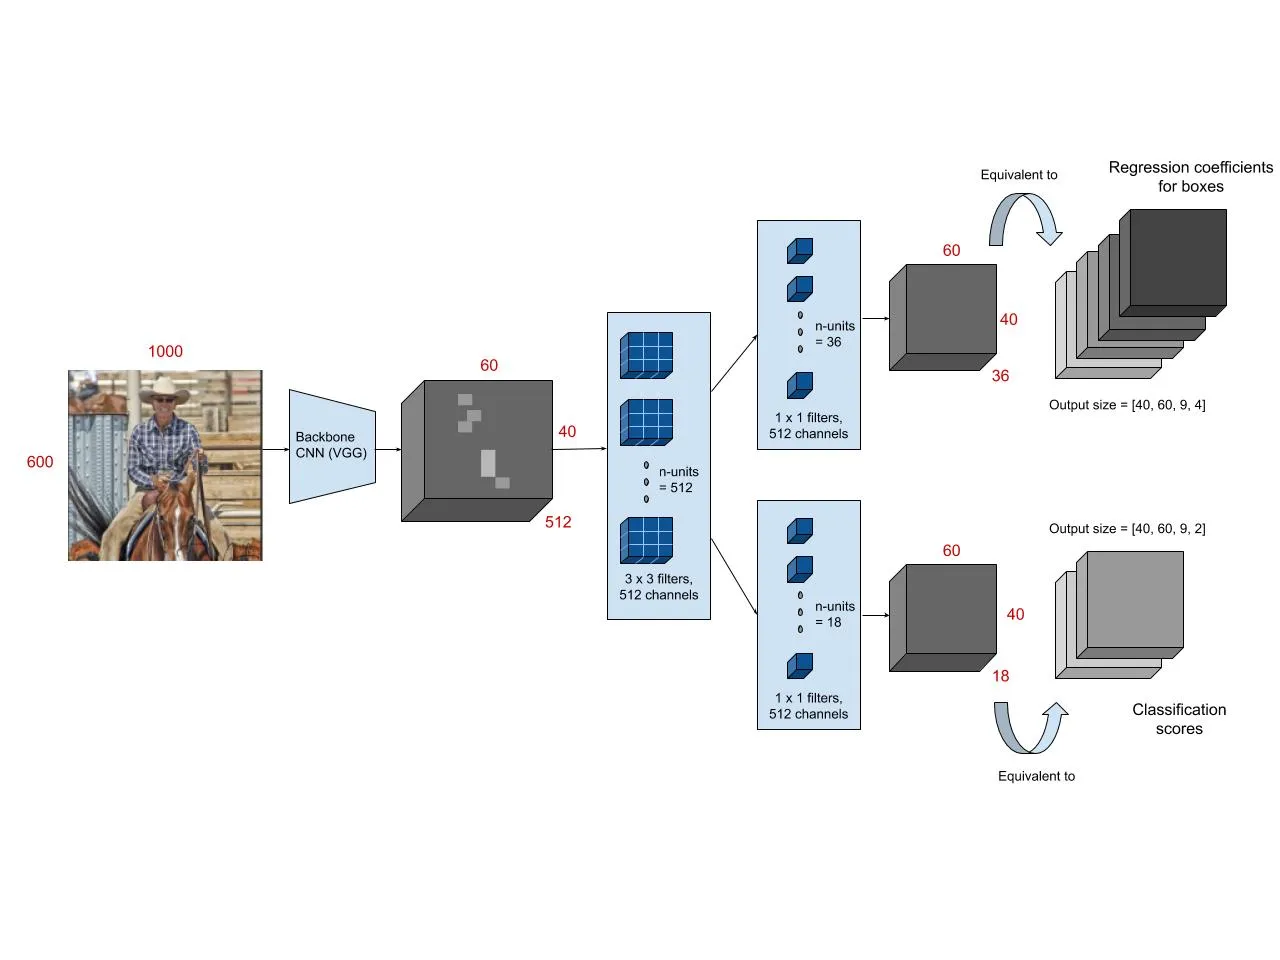

### Architecture
- The region proposal network (RPN) starts with the input image being fed into the backbone convolutional neural network. The input image is first   resized such that it’s shortest side is 600px with the longer side not exceeding 1000px.
  
- The output features of the backbone network (indicated by H x W) are usually much smaller than the input image depending on the stride of the backbone network. For both the possible backbone networks used in the paper (VGG, ZF-Net) the network stride is 16. This means that two consecutive pixels in the backbone output features correspond to two points 16 pixels apart in the input image.

  
- For every point in the output feature map, the network has to learn whether an object is present in the input image at its corresponding location and estimate its size. This is done by placing a set of “Anchors” on the input image for each location on the output feature map from the backbone network. These anchors indicate possible objects in various sizes and aspect ratios at this location. The figure below shows 9 possible anchors in 3 different aspect ratios and 3 different sizes placed on the input image for a point A on the output feature map. For the PASCAL challenge, the anchors used have 3 scales of box area 128², 256², 512² and 3 aspect ratios of 1:1, 1:2 and 2:1.

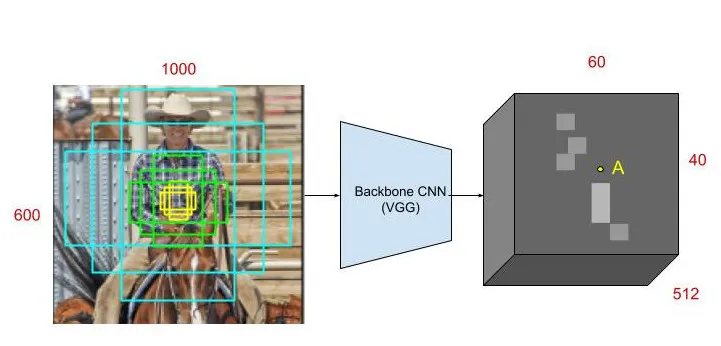

- As the network moves through each pixel in the output feature map, it has to check whether these k corresponding anchors spanning the input image actually contain objects, and refine these anchors’ coordinates to give bounding boxes as “Object proposals” or regions of interest.
- First, a 3 x 3 convolution with 512 units is applied to the backbone feature map as shown in Figure 1, to give a 512-d feature map for every location. This is followed by two sibling layers: a 1 x 1 convolution layer with 18 units for object classification, and a 1 x 1 convolution with 36 units for bounding box regression.
- The 18 units in the classification branch give an output of size (H, W, 18). This output is used to give probabilities of whether or not each point in the backbone feature map (size: H x W) contains an object within all 9 of the anchors at that point.
- The 36 units in the regression branch give an output of size (H, W, 36). This output is used to give the 4 regression coefficients of each of the 9 anchors for every point in the backbone feature map (size: H x W). These regression coefficients are used to improve the coordinates of the anchors that contain objects.

### Training and Loss functions

- The output feature map consists of about 40 x 60 locations, corresponding to 40*60*9 ~ 20k anchors in total. At train time, all the anchors that cross the boundary are ignored so that they do not contribute to the loss. This leaves about 6k anchors per image.
- An anchor is considered to be a “positive” sample if it satisfies either of the two conditions — a) The anchor has the highest IoU (Intersection over Union, a measure of overlap) with a groundtruth box; b) The anchor has an IoU greater than 0.7 with any groundtruth box. The same groundtruth box can cause multiple anchors to be assigned positive labels.
- An anchor is labeled “negative” if its IoU with all groundtruth boxes is less than 0.3. The remaining anchors (neither positive nor negative) are disregarded for RPN training.
- Each mini-batch for training the RPN comes from a single image. Sampling all the anchors from this image would bias the learning process toward negative samples, and so 128 positive and 128 negative samples are randomly selected to form the batch, padding with additional negative samples if there are an insufficient number of positives.
- The training loss for the RPN is also a multi-task loss, given by:
  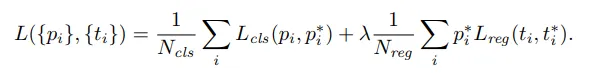

- Here i is the index of the anchor in the mini-batch. The classification loss L𝒸ₗₛ(pᵢ, pᵢ*) is the log loss over two classes (object vs not object). pᵢ is the output score from the classification branch for anchor i, and pᵢ* is the groundtruth label (1 or 0).
- The regression loss Lᵣₑ(tᵢ, tᵢ*) is activated only if the anchor actually contains an object i.e., the groundtruth pᵢ* is 1. The term tᵢ is the output prediction of the regression layer and consists of 4 variables [tₓ, tᵧ, tw, tₕ]. The regression target tᵢ* is calculated as-
  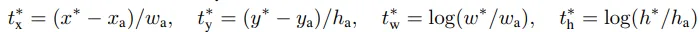

- Here x, y, w, and h correspond to the (x, y) coordinates of the box centre and the height h and width w of the box. xₐ, x* stand for the coordinates of the anchor box and its corresponding groundtruth bounding box.
- Remember that all k (= 9) of the anchor boxes have different regressors that do not share weights. So the regression loss for an anchor i is applied to its corresponding regressor (if it is a positive sample).
- At test time, the learned regression output tᵢ can be applied to its corresponding anchor box (that is predicted positive), and the x, y, w, h parameters for the predicted object proposal bounding box can be back-calculated from
  

### Test time details
At test time, the 20k anchors from each image go through a series of post-processing steps to send in the object proposal bounding boxes.

- The regression coefficients are applied to the anchors for precise localization. This gives precise bounding boxes.
- All the boxes are arranged according to their cls scores. Then, a non-maximum suppression (NMS) is applied with a threshold of 0.7: That is, from the top down, all of the bounding boxes which have an IoU of greater than 0.7 with another bounding box are discarded. Thus the highest-scoring bounding box is retained for a group of overlapping boxes.
- This gives about 2k proposals per image.
- The cross-boundary bounding boxes are retained and clipped to image boundary.
- While using these object proposals to train the Fast R-CNN detection pipeline, all 2k proposals from the RPN are used. At test time for Fast R-CNN detection, only the Top N proposals from the RPN are chosen.

### Object detection: Faster R-CNN (RPN + Fast R-CNN)
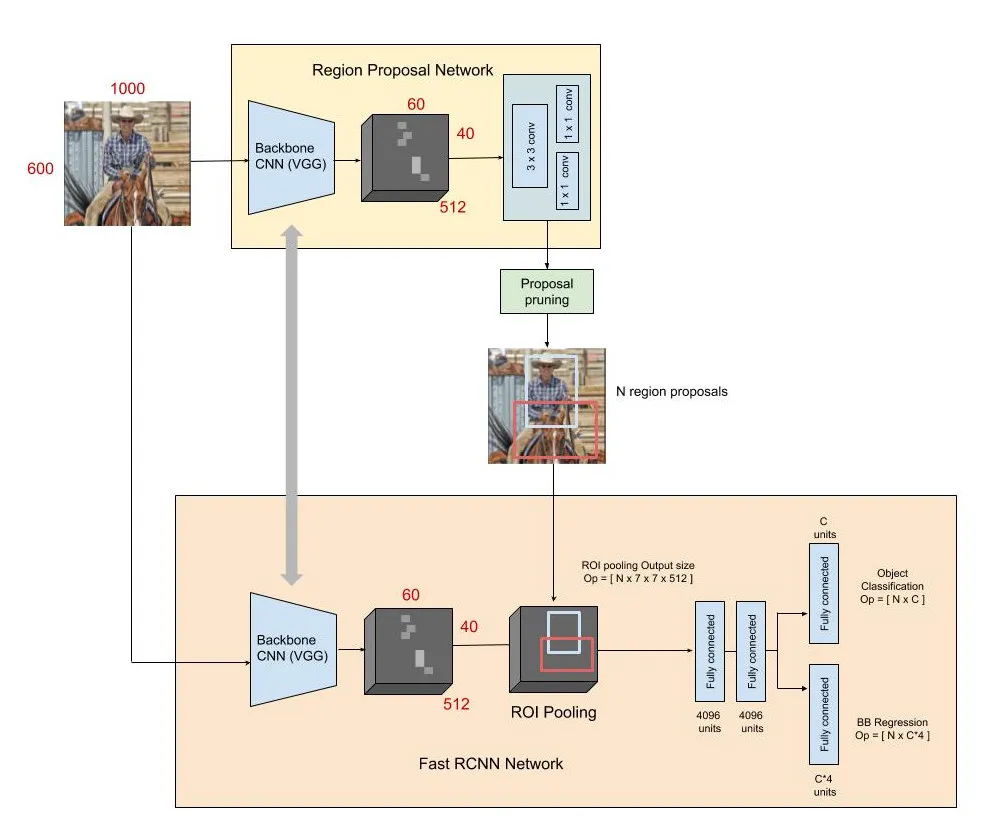

The Faster R-CNN architecture consists of the RPN as a region proposal algorithm and the Fast R-CNN as a detector network.

### Fast R-CNN as a detector for Faster R-CNN
The Fast R-CNN detector also consists of a CNN backbone, an ROI pooling layer and fully connected layers followed by two sibling branches for classification and bounding box regression as shown in Figure 3.

- The input image is first passed through the backbone CNN to get the feature map (Feature size: 60, 40, 512). Besides test time efficiency, another key reason using an RPN as a proposal generator makes sense is the advantages of weight sharing between the RPN backbone and the Fast R-CNN detector backbone.
- Next, the bounding box proposals from the RPN are used to pool features from the backbone feature map. This is done by the ROI pooling layer. The ROI pooling layer, in essence, works by a) Taking the region corresponding to a proposal from the backbone feature map; b) Dividing this region into a fixed number of sub-windows; c) Performing max-pooling over these sub-windows to give a fixed size output. To understand the details of the ROI pooling layer and it’s advantages, read Fast R-CNN.
- The output from the ROI pooling layer has a size of (N, 7, 7, 512) where N is the number of proposals from the region proposal algorithm. After passing them through two fully connected layers, the features are fed into the sibling classification and regression branches.
- Note that these classification and detection branches are different from those of the RPN. Here the classification layer has C units for each of the classes in the detection task (including a catch-all background class). The features are passed through a softmax layer to get the classification scores — the probability of a proposal belonging to each class. The regression layer coefficients are used to improve the predicted bounding boxes. Here the regressor is size agnostic, (unlike the RPN) but is specific to each class. That is, all the classes have individual regressors with 4 parameters each corresponding to C*4 output units in the regression layer.
- For more details on how the Faster R-CNN is trained and its loss functions refer to Fast R-CNN.
  
### 4 Step Alternating training
In order to force the network to share the weights of the CNN backbone between the RPN and the detector, the authors use a 4 step training method:

a) The RPN is trained independently as described above. The backbone CNN for this task is initialized with weights from a network trained for an ImageNet classification task, and is then fine-tuned for the region proposal task.
b) The Fast R-CNN detector network is also trained independently. The backbone CNN for this task is initialized with weights from a network trained for an ImageNet classification task, and is then fine-tuned for the object detection task. The RPN weights are fixed and the proposals from the RPN are used to train the Faster R-CNN.
c) The RPN is now initialized with weights from this Faster R-CNN, and fine-tuned for the region proposal task. This time, weights in the common layers between the RPN and detector remain fixed, and only the layers unique to the RPN are fine-tuned. This is the final RPN.
d) Once again using the new RPN, the Fast R-CNN detector is fine-tuned. Again, only the layers unique to the detector network are fine-tuned and the common layer weights are fixed.

This gives a Faster R-CNN detection framework that has shared convolutional layers.

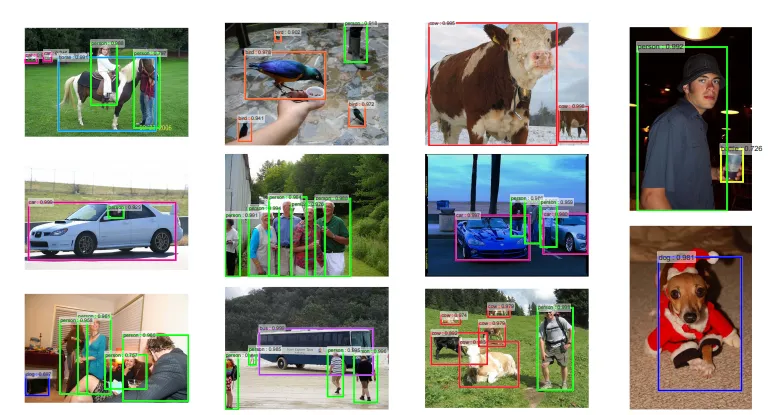

### Results
- In all the experiments on the PASCAL datasets, Fast R-CNN was chosen as a detector. The use of the RPN+ZF backbone as just a proposal network (without sharing weights with the detector) matched the performance of using “Selective Search” (SS) as a region proposal algorithm. This already gives us comparable results with a large decrease in detection time. RPN+VGG backbone as just a proposal network with unshared weights performs slightly better than the SS region proposal baseline. When using shared weights with the detector, both the ZF and VGG backbones in RPN surpassed the performance of the SS baseline. This along with a large number of other experiments validated the use of RPN as a region proposal method.
Detection with a VGG RPN takes 198ms compared to the 1.8 seconds of Selective Search.
- The other experiments performed validate the use of NMS, and the use of separate classification and regression branches. The classification branch used to rank proposals by score seems to be an important factor in maintaining a reasonably high recall vs IoU overlap ratio even when the number of object proposals is reduced.
- In ablation studies to observe the importance of scale and aspect ratios of anchor boxes, the authors find that using 3 scales with a single aspect ratio works almost as well as 3 scales and 3 aspect ratios. Depending on the task and the dataset, these ratios and scales can be modified. Using a single anchor at each location causes the mAP to drop considerably.


### 2. Discuss the advantages of using the Region Proposal Network (RPN) in Faster R-CNN compared to traditional object detection approache.

The **Region Proposal Network (RPN)** in Faster R-CNN introduces significant advantages over traditional object detection approaches, particularly in terms of efficiency, accuracy, and integration into an end-to-end trainable system. Here’s a detailed comparison of the benefits RPN provides:

---

### **1. Efficiency**
- **Traditional Approaches**:
  - Methods like Selective Search or EdgeBoxes rely on hand-crafted algorithms to generate region proposals.
  - These are computationally expensive and time-consuming because they perform exhaustive search over potential regions, often analyzing the entire image at multiple scales and aspect ratios.

- **RPN**:
  - RPN is a lightweight, fully convolutional network that directly generates region proposals from feature maps.
  - By leveraging shared convolutional features, it eliminates the need for redundant computations, significantly speeding up the region proposal process.
  - Generates high-quality proposals at a fraction of the computational cost of traditional methods.

---

### **2. End-to-End Integration**
- **Traditional Approaches**:
  - Region proposal generation and classification are decoupled, requiring separate models or processing steps.
  - This disjointed nature makes the pipeline harder to optimize and slows down inference.

- **RPN**:
  - Fully integrated with the object detection pipeline, sharing the same feature maps as the classification and bounding box regression layers.
  - Enables joint optimization during training, where the RPN learns to generate better proposals tailored to the detection task.

---

### **3. Higher Quality Region Proposals**
- **Traditional Approaches**:
  - Hand-crafted methods often produce redundant or irrelevant proposals (e.g., background regions) because they lack adaptive learning capabilities.
  - Limited in capturing complex object shapes or varying appearances.

- **RPN**:
  - Learns to generate **task-specific proposals**, focusing on regions likely to contain objects.
  - Adapts dynamically to the data and detects objects across a wide range of scales and aspect ratios using anchor boxes.
  - Produces fewer but higher-quality proposals, reducing noise for the downstream detection head.

---

### **4. Scalability**
- **Traditional Approaches**:
  - Limited scalability to high-resolution images or large datasets due to computational bottlenecks.
  - Struggle to maintain performance for real-time applications.

- **RPN**:
  - Scales naturally with the feature extraction backbone, benefiting from advances in convolutional neural network architectures.
  - Can handle high-resolution images efficiently, making it suitable for applications like video surveillance and autonomous driving.

---

### **5. Speed**
- **Traditional Approaches**:
  - Slow because they analyze images exhaustively without leveraging learned features.
  - Typically unsuitable for real-time object detection tasks.

- **RPN**:
  - Achieves real-time proposal generation by performing a single forward pass over the shared feature map.
  - Its efficiency makes Faster R-CNN significantly faster than earlier detection frameworks like R-CNN and Fast R-CNN.

---

### **6. Robustness to Variations**
- **Traditional Approaches**:
  - Limited ability to generalize to diverse object sizes, shapes, and cluttered backgrounds due to reliance on fixed heuristics.
  - Prone to missing small objects or heavily overlapping objects.

- **RPN**:
  - Uses **anchor boxes** of multiple scales and aspect ratios to handle objects of varying sizes and shapes.
  - Trained to optimize objectness scores, improving robustness in challenging scenarios such as occlusion or dense scenes.

---

### **7. Unified Architecture**
- **Traditional Approaches**:
  - Require separate systems for feature extraction, proposal generation, and classification, resulting in complex pipelines.
  
- **RPN**:
  - Provides a seamless, unified architecture where feature extraction and proposal generation are tightly coupled.
  - Simplifies the object detection framework while maintaining high performance.

---

### **Summary of RPN Advantages**

| **Feature**                     | **Traditional Approaches**                | **Region Proposal Network (RPN)**               |
|----------------------------------|-------------------------------------------|------------------------------------------------|
| **Speed**                        | Computationally expensive                 | Lightweight and efficient                      |
| **Quality of Proposals**         | Redundant or irrelevant                   | Task-specific, high-quality proposals          |
| **Scalability**                  | Limited scalability                       | Scales with feature extraction backbone        |
| **Integration**                  | Decoupled, non-trainable                  | End-to-end trainable and integrated            |
| **Adaptability**                 | Fixed heuristics                          | Learns to adapt to data and task               |
| **Robustness**                   | Struggles with small/overlapping objects  | Handles diverse scales and aspect ratios well  |

---

### **Conclusion**
The RPN is a game-changing component of Faster R-CNN. By replacing traditional proposal-generation methods with a learnable, efficient network, it significantly boosts the speed, accuracy, and adaptability of the detection pipeline. This innovation has paved the way for modern object detection frameworks to achieve high performance in both precision and computational efficiency.

### 3. Explain the training process of Faster R-CNN. How are the region proposal network (RPN) and the Fast R-CNN detector trained jointly.

The training process of **Faster R-CNN** involves optimizing two main components: the **Region Proposal Network (RPN)** and the **Detection Head**, which are trained jointly in an end-to-end manner. Here's a detailed explanation of the training process:

---

### **1. Overview of the Training Pipeline**
The training process is divided into two main stages:
1. **Training the Region Proposal Network (RPN)**:
   - The RPN is trained to generate high-quality region proposals, focusing on areas likely to contain objects.
2. **Training the Detection Head**:
   - The Detection Head is trained to classify the proposals into object categories and refine their bounding boxes.

During training, the backbone CNN (e.g., ResNet, VGG) is shared between the RPN and Detection Head, allowing feature extraction to be optimized across both tasks.

---

### **2. Training Steps**

#### **A. Input Preprocessing**
- **Input**: 
  - An image and its corresponding ground truth annotations (object class labels and bounding box coordinates).
- **Output**:
  - A set of anchor boxes and labels for RPN training, derived by matching anchors with ground truth boxes:
    - **Positive Anchors**: Overlap (IoU) ≥ 0.7 with any ground truth box.
    - **Negative Anchors**: Overlap (IoU) ≤ 0.3 with all ground truth boxes.
    - **Ignored Anchors**: IoU in the range (0.3, 0.7).

---

#### **B. Training the Region Proposal Network (RPN)**
- **Objective**:
  - Train the RPN to predict:
    1. **Objectness Scores**: Whether an anchor contains an object.
    2. **Bounding Box Coordinates**: Refinements for anchors to match ground truth.

- **Loss Function**:
  - The RPN loss combines two terms:
    1. **Classification Loss** (\(L_{cls}\)):
       - Measures the objectness prediction accuracy (binary classification: object vs. background).
       - Typically uses cross-entropy loss.
    2. **Regression Loss** (\(L_{reg}\)):
       - Measures the accuracy of predicted bounding box refinements using Smooth L1 Loss.
  - Overall RPN Loss:
    \[
    L_{RPN} = L_{cls} + \lambda \cdot L_{reg}
    \]
    where \(\lambda\) is a balancing weight.

- **Training Details**:
  - The RPN outputs a fixed number of proposals (e.g., 2000), filtered based on objectness scores.
  - Non-Maximum Suppression (NMS) is applied to remove redundant proposals.

---

#### **C. Preparing Region Proposals for Detection Head**
- Proposals generated by the RPN are assigned labels for training the detection head:
  - **Positive Proposals**: IoU ≥ 0.5 with any ground truth box.
  - **Negative Proposals**: IoU < 0.5 with all ground truth boxes.

---

#### **D. Training the Detection Head**
- **Objective**:
  - Train the Detection Head to:
    1. Classify each region proposal into object categories or background.
    2. Refine the bounding box coordinates for more accurate localization.

- **Loss Function**:
  - The Detection Head loss also combines two terms:
    1. **Classification Loss** (\(L_{cls}\)):
       - Measures the accuracy of object category prediction using cross-entropy loss.
    2. **Regression Loss** (\(L_{reg}\)):
       - Measures the accuracy of bounding box refinements using Smooth L1 Loss.
  - Overall Detection Loss:
    \[
    L_{det} = L_{cls} + \lambda \cdot L_{reg}
    \]

- **Training Details**:
  - Features for each proposal are extracted using **RoI Pooling** or **RoI Align**.
  - A fully connected network processes these features to make predictions.

---

### **3. End-to-End Joint Training**
- **Shared Backbone**:
  - The feature extraction backbone is shared between the RPN and the Detection Head, allowing gradients from both tasks to update the backbone weights.
- **Multi-Task Loss**:
  - The combined loss function for Faster R-CNN includes both RPN and Detection Head losses:
    \[
    L = L_{RPN} + L_{det}
    \]
  - This ensures that the entire model is optimized in a unified manner.

---

### **4. Mini-Batch Sampling**
- Faster R-CNN uses mini-batches of proposals during training:
  - For the RPN, mini-batches are sampled from anchors (positive and negative).
  - For the Detection Head, mini-batches are sampled from region proposals.
  - A typical ratio is 1:3 (positive:negative) to balance learning.

---

### **5. Implementation Notes**
- **Backpropagation**:
  - Gradients flow through the entire pipeline, including the backbone, RPN, and Detection Head.
- **Anchor Boxes**:
  - Anchor boxes are predefined at different scales and aspect ratios to handle objects of varying sizes.
- **Non-Maximum Suppression (NMS)**:
  - Used in the RPN to filter overlapping proposals and retain only the most relevant ones.

---

### **6. Stages of Training**
- Training Faster R-CNN typically involves iterative optimization:
  1. Train the RPN separately to ensure high-quality proposals.
  2. Train the Detection Head using the proposals generated by the RPN.
  3. Fine-tune the entire model jointly to refine feature extraction, proposal generation, and detection.

---

### **7. Summary of Training Steps**
| **Stage**                 | **Input**                   | **Output**                              | **Loss Function**                |
|---------------------------|-----------------------------|-----------------------------------------|----------------------------------|
| **RPN Training**          | Feature maps, ground truth | Region proposals (objectness + bbox)   | \(L_{RPN} = L_{cls} + L_{reg}\) |
| **Detection Head Training** | Region proposals, ground truth | Class labels, refined bounding boxes   | \(L_{det} = L_{cls} + L_{reg}\) |
| **Joint Training**        | Entire pipeline            | Optimized feature maps, proposals, detections | \(L = L_{RPN} + L_{det}\)       |

---

### **Advantages of the Training Process**
- **End-to-End Optimization**:
  - Jointly trains the RPN and Detection Head, improving coordination between proposal generation and detection.
- **Efficient Resource Usage**:
  - Shared backbone reduces computational redundancy.
- **Flexibility**:
  - The system can adapt to objects of various sizes and aspect ratios through anchor box design and training.

Faster R-CNN’s training process ensures a balance between speed, accuracy, and scalability, making it highly effective for object detection tasks.

---

In **Faster R-CNN**, the **Region Proposal Network (RPN)** and the **Fast R-CNN detector** are trained jointly in an end-to-end manner. This joint training ensures that the feature extraction backbone is shared and optimized for both tasks: region proposal generation and object detection. Here’s how the joint training process works:

---

### **1. Unified Backbone for Shared Features**
- The **backbone CNN** (e.g., ResNet, VGG) extracts feature maps from the input image.
- Both the RPN and the Fast R-CNN detection head operate on the same feature maps, ensuring efficient computation and consistent feature representation.

---

### **2. Training Workflow**
#### **Step 1: RPN Training**
- The RPN processes the feature maps to generate:
  1. **Objectness Scores**: Determines whether each anchor box contains an object.
  2. **Bounding Box Refinements**: Adjusts the anchor boxes to better match ground truth objects.
  
- **Loss Function for RPN**:
  \[
  L_{RPN} = L_{cls} + \lambda \cdot L_{reg}
  \]
  where:
  - \(L_{cls}\): Binary cross-entropy loss for objectness classification (object vs. background).
  - \(L_{reg}\): Smooth L1 loss for bounding box regression.
  - \(\lambda\): Weighting factor for balancing the two loss components.

- The RPN generates region proposals (e.g., 2000 proposals), which are passed to the next stage.

---

#### **Step 2: Proposal Sampling**
- The RPN outputs are filtered:
  - **Positive Proposals**: Regions with high overlap (IoU ≥ 0.5) with ground truth boxes.
  - **Negative Proposals**: Regions with low overlap (IoU < 0.5) with all ground truth boxes.
- A fixed number of positive and negative proposals are sampled (e.g., 1:3 ratio) for training the Fast R-CNN detector.

---

#### **Step 3: Fast R-CNN Training**
- The proposals from the RPN are aligned with the feature map using **RoI Pooling** or **RoI Align**, producing fixed-size feature vectors.
- These feature vectors are passed through the **Fast R-CNN detection head**, which outputs:
  1. **Class Predictions**: Classifies each proposal into an object class or background.
  2. **Bounding Box Refinements**: Further refines the bounding boxes for better localization.

- **Loss Function for Fast R-CNN**:
  \[
  L_{FastRCNN} = L_{cls} + \lambda \cdot L_{reg}
  \]
  where:
  - \(L_{cls}\): Cross-entropy loss for multi-class classification.
  - \(L_{reg}\): Smooth L1 loss for bounding box regression.

---

### **3. Joint Training Process**
In joint training, the **RPN** and **Fast R-CNN** are trained simultaneously with a **multi-task loss**. The backbone CNN is updated based on the combined gradients from both tasks.

#### **Combined Multi-Task Loss**
The overall loss for Faster R-CNN is the sum of the RPN and Fast R-CNN losses:
\[
L = L_{RPN} + L_{FastRCNN}
\]
This loss ensures that:
- The RPN learns to generate better proposals for the detector.
- The Fast R-CNN detector improves classification and bounding box regression performance.
- The backbone CNN is optimized for both tasks, benefiting feature extraction across the pipeline.

---

### **4. Training Algorithm**
1. **Forward Pass**:
   - The input image is passed through the backbone CNN to generate feature maps.
   - The RPN generates region proposals from the feature maps.
   - The proposals are aligned with the feature maps using RoI Pooling/Align.
   - The Fast R-CNN detector processes the aligned features to classify objects and refine bounding boxes.

2. **Loss Computation**:
   - Compute the RPN loss (\(L_{RPN}\)).
   - Compute the Fast R-CNN loss (\(L_{FastRCNN}\)).
   - Combine the losses into a multi-task loss (\(L = L_{RPN} + L_{FastRCNN}\)).

3. **Backward Pass**:
   - Backpropagate the combined loss through the detection head, RPN, and backbone.
   - Update the weights of all components using a single optimization step.

---

### **5. Benefits of Joint Training**
- **Feature Sharing**:
  - The shared backbone ensures that features learned for region proposals are also useful for object detection, improving efficiency and performance.
  
- **End-to-End Optimization**:
  - Joint training allows the model to optimize region proposal generation and detection simultaneously, resulting in higher-quality proposals and detections.

- **Task-Specific Adaptation**:
  - The RPN learns to generate proposals tailored to the detection task, leading to better localization and fewer false positives.

- **Reduced Redundancy**:
  - By sharing computations across the RPN and Fast R-CNN, the model avoids redundant feature extraction, making it faster and more resource-efficient.

---

### **Summary**
In Faster R-CNN, the **RPN** and **Fast R-CNN detector** are trained jointly through a unified loss function. This training process ensures that the shared backbone and both components are optimized to work together seamlessly, resulting in a highly accurate and efficient object detection pipeline.

### 4. Discuss the role of anchor boxes in the Region Proposal Network (RPN) of Faster R-CNN. How are anchor boxes used to generate region proposals.

### **Role of Anchor Boxes in the Region Proposal Network (RPN) of Faster R-CNN**

**Anchor boxes** are a critical component in the **Region Proposal Network (RPN)** of Faster R-CNN, enabling the network to handle objects of various sizes, shapes, and aspect ratios effectively. Here’s a detailed discussion of their role:

---

### **1. What are Anchor Boxes?**
- Anchor boxes are **predefined bounding boxes** of different scales and aspect ratios that are placed at each spatial location in the feature map.
- They act as references or templates for predicting object locations and sizes.
- Each anchor box represents a potential object candidate, and the RPN learns to adjust these boxes to fit the actual objects in the image.

---

### **2. Purpose of Anchor Boxes**
The anchor boxes serve multiple purposes in the RPN:

#### **A. Handling Objects of Different Sizes and Shapes**
- Objects in real-world images vary greatly in size and aspect ratio (e.g., a car is wide, a person is tall, and a ball is nearly square).
- Anchor boxes of different:
  - **Scales** (e.g., small, medium, large)
  - **Aspect Ratios** (e.g., 1:1, 2:1, 1:2)
  help the RPN detect objects of diverse shapes and sizes effectively.

#### **B. Reducing Computational Complexity**
- Instead of predicting bounding boxes from scratch, the RPN refines predefined anchor boxes.
- This reduces the search space for bounding box prediction, making the process computationally efficient.

#### **C. Generating Dense Region Proposals**
- By placing anchor boxes at every location of the feature map, the RPN ensures dense coverage of the image.
- This maximizes the likelihood of overlapping an anchor box with each ground truth object.

---

### **3. How Anchor Boxes Work in the RPN**
#### **A. Anchor Placement**
- Anchor boxes are placed at **every spatial location** in the feature map generated by the backbone.
- For example, if the feature map size is \( W \times H \), and there are \( k \) anchor boxes per location, the total number of anchor boxes is \( W \times H \times k \).

#### **B. Matching Anchors to Ground Truth**
- Each anchor box is matched with the ground truth bounding boxes based on **Intersection over Union (IoU)**:
  1. **Positive Anchors**:
     - Anchors with IoU ≥ 0.7 with any ground truth box.
  2. **Negative Anchors**:
     - Anchors with IoU ≤ 0.3 with all ground truth boxes.
  3. **Ignored Anchors**:
     - Anchors with IoU in the range (0.3, 0.7).

#### **C. Learning Adjustments**
- The RPN predicts two outputs for each anchor box:
  1. **Objectness Score**:
     - Indicates whether the anchor contains an object or background.
  2. **Bounding Box Refinements**:
     - Adjusts the anchor box coordinates to better fit the ground truth box.

---

### **4. Benefits of Using Anchor Boxes**
#### **A. Flexible Detection**
- Anchor boxes enable the RPN to handle objects of varying sizes and shapes without requiring different network architectures or excessive pre-processing.

#### **B. Efficient Training**
- By starting with predefined anchor boxes, the RPN can focus on learning offsets rather than absolute box coordinates, simplifying the learning task.

#### **C. Scalability**
- The concept of anchor boxes can be adapted to different backbone architectures and feature map resolutions, making it highly scalable.

#### **D. Dense and Robust Proposals**
- The dense placement of anchor boxes ensures robust coverage of objects in the image, even in complex or crowded scenes.

---

### **5. Anchor Design**
The design of anchor boxes is crucial for achieving high detection accuracy:
- **Number of Anchors per Location**:
  - Typically, 9 anchors are used per location (3 scales × 3 aspect ratios).
- **Anchor Scales**:
  - Represent the relative size of the anchor (e.g., small, medium, large).
- **Anchor Aspect Ratios**:
  - Represent the shape of the anchor (e.g., square, wide, tall).

Well-designed anchors ensure that objects of all sizes and shapes are adequately covered.

---

### **6. Challenges with Anchor Boxes**
#### **A. Imbalance between Positive and Negative Anchors**
- Most anchors are negative (background), which can lead to class imbalance during training. Solutions include:
  - Sampling a balanced ratio of positive and negative anchors (e.g., 1:3).
  - Using focal loss to down-weight easy negatives.

#### **B. Small Object Detection**
- Small objects may have low IoU with anchor boxes, leading to poor detection. Using higher-resolution feature maps or additional scales can help.

#### **C. Computational Overhead**
- Dense placement of anchor boxes increases the number of proposals, requiring efficient filtering (e.g., Non-Maximum Suppression) to reduce redundancy.

---

### **7. Summary of Anchor Box Roles**
| **Role**                      | **Description**                                                                                   |
|--------------------------------|---------------------------------------------------------------------------------------------------|
| **Reference for Prediction**  | Provides starting points for bounding box regression, reducing the complexity of predictions.     |
| **Handling Scale/Shape Variance** | Allows the RPN to detect objects of various sizes and aspect ratios efficiently.                |
| **Dense Image Coverage**       | Ensures that all potential object regions are considered.                                         |
| **Efficiency**                 | Simplifies the learning task by refining predefined boxes rather than predicting from scratch.    |
| **Flexibility**                | Adaptable to different backbone architectures and feature map resolutions.                       |

---

Anchor boxes are central to the **Region Proposal Network (RPN)** in Faster R-CNN for generating **region proposals**. They provide a set of predefined bounding boxes that act as templates for detecting objects of various sizes and aspect ratios. Here’s a detailed explanation of how anchor boxes are used to generate region proposals:

---

### **1. Anchor Box Placement**
- **Anchor boxes** are placed at every spatial location in the **feature map** output by the backbone CNN.
- Each location in the feature map corresponds to a receptive field in the input image.
- At each location, several anchor boxes (e.g., 9 anchors per location) are defined, differing in:
  - **Scales**: Representing object sizes (e.g., small, medium, large).
  - **Aspect Ratios**: Representing object shapes (e.g., square, wide, tall).

For a feature map of size \( H \times W \) with \( k \) anchors per location, the total number of anchor boxes is \( H \times W \times k \).

---

### **2. Processing Anchor Boxes**
Each anchor box undergoes a series of operations to generate region proposals:

#### **A. Classification (Objectness Prediction)**
- For every anchor box, the RPN predicts whether it contains an object (**foreground**) or belongs to the background.
- This is a **binary classification task**:
  - **Positive Anchors**: Anchor boxes with an IoU (Intersection over Union) ≥ 0.7 with any ground truth box.
  - **Negative Anchors**: Anchor boxes with an IoU ≤ 0.3 with all ground truth boxes.
  - Anchors with 0.3 < IoU < 0.7 are ignored during training.

#### **B. Bounding Box Regression**
- For each anchor box classified as positive, the RPN predicts **offsets** to refine its coordinates to better match the corresponding ground truth bounding box.
- The regression outputs are:
  \[
  \Delta x, \Delta y, \Delta w, \Delta h
  \]
  where:
  - \( \Delta x, \Delta y \): Shifts for the anchor box center.
  - \( \Delta w, \Delta h \): Scaling factors for the anchor box width and height.

#### **C. Proposal Generation**
- Using the predicted offsets, the anchor boxes are transformed into **region proposals**:
  \[
  x_{\text{proposal}} = x_{\text{anchor}} + \Delta x \cdot w_{\text{anchor}}
  \]
  \[
  y_{\text{proposal}} = y_{\text{anchor}} + \Delta y \cdot h_{\text{anchor}}
  \]
  \[
  w_{\text{proposal}} = w_{\text{anchor}} \cdot \exp(\Delta w)
  \]
  \[
  h_{\text{proposal}} = h_{\text{anchor}} \cdot \exp(\Delta h)
  \]

---

### **3. Filtering Region Proposals**
The RPN generates a large number of proposals, many of which overlap or are irrelevant. To refine the proposals, the following steps are taken:

#### **A. Non-Maximum Suppression (NMS)**
- Proposals with high overlap (IoU) are redundant. NMS retains only the highest-scoring proposals, reducing the number of proposals while maintaining diversity.

#### **B. Proposal Scoring**
- The RPN assigns a confidence score (objectness probability) to each region proposal based on the classification output.
- Only the top-N proposals (e.g., 2000 proposals during training, 300 during inference) are retained.

#### **C. Bounding Box Clipping**
- Proposals that extend beyond image boundaries are clipped to fit within the image dimensions.

---

### **4. Training Anchor Boxes to Generate Proposals**
During training, the RPN optimizes the anchor box predictions using a **multi-task loss**:
1. **Classification Loss (\(L_{cls}\))**:
   - Binary cross-entropy loss for objectness prediction.
2. **Regression Loss (\(L_{reg}\))**:
   - Smooth L1 loss for bounding box coordinate adjustments.

The total RPN loss is:
\[
L_{RPN} = L_{cls} + \lambda \cdot L_{reg}
\]
where \(\lambda\) balances the two loss components.

---

### **5. Examples of Anchor Box Usage**
#### **A. Small Objects**
- Small anchor boxes are more likely to overlap small objects, making them good candidates for positive proposals.

#### **B. Large Objects**
- Larger anchor boxes are refined to detect objects with a broader spatial extent.

#### **C. Aspect Ratios**
- Anchors with different aspect ratios (e.g., 2:1 for wide objects) align better with objects of similar shapes, improving detection accuracy.

---

### **6. Advantages of Anchor Boxes for Region Proposals**
- **Dense Coverage**:
  - Placing anchor boxes densely across the image ensures that most objects are covered by at least one anchor.
- **Scalability**:
  - The use of multiple scales and aspect ratios allows the RPN to handle diverse object sizes and shapes without requiring multiple network passes.
- **Simplifies Learning**:
  - Anchor boxes act as starting points, reducing the complexity of learning bounding box coordinates from scratch.

---

### **7. Summary of Anchor Box Role in Region Proposals**
| **Step**                     | **Role of Anchor Boxes**                                                |
|-------------------------------|-------------------------------------------------------------------------|
| **Placement**                | Provide predefined bounding boxes at each feature map location.         |
| **Classification**           | Determine whether an anchor contains an object (positive) or background.|
| **Bounding Box Regression**  | Predict offsets to refine anchor box coordinates to match ground truth. |
| **Proposal Generation**      | Transform anchors into region proposals using predicted offsets.        |
| **Filtering**                | Use NMS and proposal scoring to retain high-quality, non-redundant regions.|

---

### **Conclusion**
Anchor boxes are the foundation of the RPN's ability to generate **region proposals**. By acting as initial bounding box templates and being refined through classification and regression, they enable the RPN to efficiently and accurately propose regions likely to contain objects. This process is essential for the overall performance of Faster R-CNN.

### 5. Evaluate the performance of Faster R-CNN on standard object detection benchmarks such as COCO and Pascal VOC. Discuss its strengths, limitations, and potential areas for improvement.


The performance of **Faster R-CNN** on standard object detection benchmarks such as **COCO** and **Pascal VOC** has been widely studied and demonstrates its effectiveness as a robust object detection framework. Below is an evaluation of its performance on these benchmarks:

---

### **1. Performance on Pascal VOC**
#### **Pascal VOC Dataset**
- Contains images from 20 object categories.
- Focuses on challenges like varying object sizes, occlusions, and cluttered backgrounds.
- Evaluation metric: **Mean Average Precision (mAP)** at a threshold IoU of 0.5 (\( \text{mAP}_{\text{IoU}=0.5} \)).

#### **Faster R-CNN Performance**
- Achieves high **mAP** scores compared to earlier methods like R-CNN and Fast R-CNN.
- Key Results:
  - **Pascal VOC 2007 test set**:
    - Faster R-CNN: ~73.2% mAP (with VGG-16 backbone).
    - Fast R-CNN: ~70.0% mAP.
    - R-CNN: ~66.0% mAP.
  - **Pascal VOC 2012 test set**:
    - Faster R-CNN: ~70.4% mAP.
    - Fast R-CNN: ~68.4% mAP.
  
#### **Advantages Observed**
- **Efficiency**: Faster R-CNN reduces detection time significantly compared to R-CNN by eliminating the need for separate region proposal computation.
- **Accuracy**: The RPN improves proposal quality, resulting in better object localization and detection.

---

### **2. Performance on COCO**
#### **COCO Dataset**
- Features 80 object categories with challenging scenarios like small object detection and dense object overlap.
- Evaluates performance using the **Average Precision (AP)** metric:
  - \( \text{AP}_{\text{IoU}=0.5} \): Similar to Pascal VOC’s mAP.
  - \( \text{AP}_{\text{IoU}=0.75} \): A stricter IoU threshold.
  - \( \text{AP}_{\text{small}}, \text{AP}_{\text{medium}}, \text{AP}_{\text{large}} \): Evaluates performance based on object sizes.

#### **Faster R-CNN Performance**
- **COCO test-dev results** (with ResNet-50/ResNet-101 backbone):
  - \( \text{AP}_{\text{IoU}=0.5} \): ~59–60%.
  - \( \text{AP} \) (average over multiple IoU thresholds): ~34–36%.
  - \( \text{AP}_{\text{small}} \): ~18–20%.
  - \( \text{AP}_{\text{medium}} \): ~37–39%.
  - \( \text{AP}_{\text{large}} \): ~47–49%.

#### **Strengths**
- **Robustness**: Handles complex scenes with multiple overlapping objects.
- **Scalability**: Adapts well to larger datasets and more diverse object categories.

#### **Challenges**
- Performance drops for **small objects** due to limited resolution in deep feature maps.
- Computational overhead remains significant compared to newer methods.

---

### **3. Comparison with Other Methods**
| **Model**         | **Pascal VOC mAP (IoU=0.5)** | **COCO AP (IoU=0.5:0.95)** | **Comments**                             |
|--------------------|-----------------------------|---------------------------|-----------------------------------------|
| R-CNN             | ~66%                        | ~19%                      | High accuracy but slow due to multi-stage pipeline. |
| Fast R-CNN        | ~70%                        | ~35%                      | Improved speed but relies on external region proposals. |
| **Faster R-CNN**  | ~73%                        | ~36%                      | End-to-end training, high accuracy, efficient pipeline. |
| Mask R-CNN        | ~76%                        | ~38%                      | Adds instance segmentation capability.   |
| YOLOv3            | ~57%                        | ~33%                      | Faster but less accurate for smaller objects. |

---

### **4. Strengths of Faster R-CNN**
- **High Accuracy**:
  - Excels in scenarios requiring precise object localization.
  - Outperforms earlier methods on benchmarks like Pascal VOC and COCO.

- **Generalization**:
  - Performs well across datasets with different characteristics, including Pascal VOC’s small-scale dataset and COCO’s large-scale dataset.

- **End-to-End Pipeline**:
  - Jointly trains the region proposal network and detection network, resulting in better integration and higher-quality proposals.

---

### **5. Limitations**
- **Computational Cost**:
  - Slower than single-stage detectors like YOLO or SSD, particularly for real-time applications.
  
- **Small Object Detection**:
  - Struggles with detecting small objects due to coarse feature maps from the backbone.

- **Proposal Redundancy**:
  - Generates a large number of proposals, requiring additional processing like Non-Maximum Suppression (NMS).

---

### **6. Improvements in Follow-Up Models**
- Models like **Mask R-CNN** and **Cascade R-CNN** build on Faster R-CNN’s framework, achieving better results by:
  - Adding instance segmentation.
  - Refining bounding box regression in multiple stages.

---

### **7. Conclusion**
Faster R-CNN remains a benchmark in object detection due to its **high accuracy and robustness**. While it’s less suitable for real-time applications compared to single-stage detectors, it continues to be a preferred choice for tasks requiring precise detection and localization. Its performance on Pascal VOC and COCO demonstrates its versatility and adaptability across diverse datasets.

---

### **Strengths, Limitations, and Potential Areas for Improvement of Faster R-CNN**

---

### **Strengths**
1. **High Detection Accuracy**:
   - Faster R-CNN provides excellent object detection performance across datasets like Pascal VOC and COCO.
   - It achieves high **mean Average Precision (mAP)**, particularly for medium and large objects.

2. **Unified End-to-End Framework**:
   - Combines the Region Proposal Network (RPN) and Fast R-CNN into a single, end-to-end trainable model.
   - Eliminates the need for external region proposal methods (e.g., Selective Search), improving efficiency.

3. **Robustness**:
   - Handles challenging scenarios like occlusions, cluttered backgrounds, and multiple object categories.
   - Generates high-quality region proposals that adapt well to complex scenes.

4. **Scalability**:
   - The architecture can leverage powerful backbone networks (e.g., ResNet, VGG, Swin Transformers) for feature extraction, improving accuracy and flexibility.

5. **Modularity**:
   - Flexible framework allows for easy integration of additional capabilities, such as instance segmentation in **Mask R-CNN** or multi-stage bounding box refinement in **Cascade R-CNN**.

---

### **Limitations**
1. **Slow Inference Speed**:
   - Although faster than R-CNN and Fast R-CNN, Faster R-CNN is still slower than single-stage detectors like YOLO and SSD.
   - Computationally expensive, making it less suitable for real-time applications.

2. **Performance on Small Objects**:
   - Struggles to detect small objects due to the downsampling in feature maps from the backbone network.
   - Small objects often have lower overlap with anchor boxes, leading to fewer positive proposals.

3. **Anchor Box Design**:
   - Anchor boxes require careful design to handle variations in object size and aspect ratios.
   - Suboptimal anchor box configuration can degrade performance, particularly for datasets with diverse object shapes.

4. **Proposal Redundancy**:
   - Generates a large number of redundant region proposals, requiring Non-Maximum Suppression (NMS) to filter them, which adds computational overhead.

5. **Training Complexity**:
   - Requires multi-task training to optimize both classification and bounding box regression.
   - Sensitive to hyperparameter choices, such as learning rates, anchor scales, and aspect ratios.

---

### **Potential Areas for Improvement**
1. **Real-Time Performance**:
   - Optimize Faster R-CNN for faster inference by reducing redundancy in the RPN or leveraging lightweight backbones like MobileNet.
   - Explore **model pruning**, **quantization**, and **knowledge distillation** to decrease computational complexity.

2. **Better Small Object Detection**:
   - Use **Feature Pyramid Networks (FPN)** to incorporate multi-scale features, enhancing the detection of small objects.
   - Improve anchor design or replace anchors with anchor-free approaches that dynamically learn bounding box proposals.

3. **Anchor-Free Methods**:
   - Replace anchor boxes with anchor-free methods, such as using keypoint-based localization (e.g., CenterNet) to simplify the proposal generation process.

4. **Improved Proposal Generation**:
   - Use techniques like **learnable query embeddings** (as in transformer-based models) instead of relying on densely placed anchor boxes.
   - Reduce redundancy in proposals to minimize the need for NMS.

5. **Integration with Vision Transformers**:
   - Incorporate **Vision Transformers (ViTs)** or hybrid architectures (e.g., Swin Transformer) for feature extraction, potentially improving accuracy and robustness.

6. **Efficient Backbone Networks**:
   - Experiment with efficient backbones like **EfficientNet** or **ConvNeXt** for better trade-offs between speed and accuracy.

7. **Adaptive Training and Loss Functions**:
   - Introduce **adaptive loss functions** (e.g., focal loss) to handle class imbalance between foreground and background during training.
   - Use **self-supervised pretraining** to improve feature representations for better generalization.

---

### **Conclusion**
Faster R-CNN is a cornerstone of modern object detection, offering high accuracy and robustness. While it excels in precision, its limitations in speed, small object detection, and anchor dependency present opportunities for innovation. By integrating multi-scale features, adopting anchor-free methods, or leveraging transformer-based backbones, Faster R-CNN can remain competitive in the evolving landscape of object detection.